# INRIA Coding DOJO ( 11-02-2019)

## Introduction

The goal of this coding dojo is to benchmark Julia's performance through a simple exercise: to compute Mandelbrot set. The Mandelbrot set is defined as all the points $c$ on the complex plane such that the function $f_c(z) = z^2 + c$ does not diverge when iterated starting from $z=0$. For this notebook, we will simplify the problem, and consider only 50 iterations. If after 50 iterations, the norm of the function is greater than 2, we will say that the point is not on the mandelbrot set. Here is a simple version of our function

In [8]:
function is_mandel(c)
    f = c
    for _ in 1:49
        f = f^2 + c
        abs(f) > 2 && return false
    end
    return true
end

is_mandel (generic function with 1 method)

We can test that, e.g., the point $c=0$ is in the mandelbrot set, as it should:

In [9]:
is_mandel(0)

true

and that the point $c=1+i$ is not on the mandelbrot set:

In [10]:
is_mandel(1+im)

false

Now that we can decide whether a point is on the mandelbrot set or not, lets compute it on a grid:

In [4]:
compute_mandel(xrange,yrange,N) = [is_mandel(x+y*im) for y in yrange, x in xrange]

compute_mandel (generic function with 1 method)

Lets make a plot to make sure this looks right:

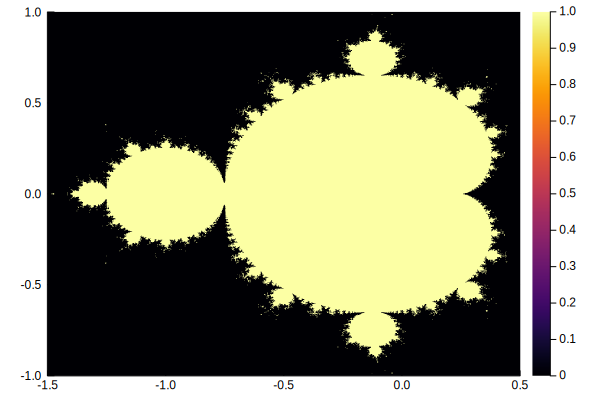

In [5]:
using Plots
N = 800
xrange = range(-1.5,0.5,length=N)    
yrange = range(-1.0,1.0,length=N)
M = compute_mandel(xrange,yrange,N);
heatmap(xrange,yrange,M)

This looks more or less ok. We will do some more careful checking later. Before that, lets write a simple version of our `is_mandel` function on `C`:

In [6]:
C_code="""
#include <complex.h>
int is_mandel(double complex c){
    double complex f = c;
    for (int i=1; i<50; ++i){
        f = f*f + c;
        if (cabs(f) > 2)
            return 0;
    }
    return 1;
}
"""
const Clib = tempname()
using Libdl
open(`gcc -fPIC -O3 -msse3 -xc -shared -o $(Clib * "." * Libdl.dlext) -`, "w") do f
    print(f, C_code)
end
c_is_mandel(c) = ccall(("is_mandel", Clib), Bool, (ComplexF64,), c)


c_is_mandel (generic function with 1 method)

Lets make sure it gives the same results as our *Julia* version

In [7]:
N = 200
xrange = range(-1.5,0.5,length=N)    
yrange = range(-1.0,1.0,length=N)
[is_mandel(x+y*im) for y in yrange, x in xrange] == [c_is_mandel(x+y*im) for y in yrange, x in xrange] 

true

Finally, before moving on, lets just make sure the running times are comparable for `c_is_mandel` and `is_mandel`. Again, we will do a more careful analysis later:

In [8]:
using BenchmarkTools
xrange = range(-1.5,0.5,length=N)    
yrange = range(-1.0,1.0,length=N)
println("Julia version of is_mandel:")
@btime [is_mandel(x+y*im) for y in yrange, x in xrange];
println("C version of is_mandel:")
@btime [c_is_mandel(x+y*im) for y in yrange, x in xrange];

Julia version of is_mandel:
  6.280 ms (5 allocations: 39.53 KiB)
C version of is_mandel:
  6.016 ms (5 allocations: 39.53 KiB)


Ok, so far so good. We can now dive into the actual problem. 

## The mandelbrot set challenge

The precise challenge we want to solve is described [here](https://benchmarksgame-team.pages.debian.net/benchmarksgame/description/mandelbrot.html#mandelbrot). We will use the provided output file to test our program with `N=200`, and then use `N=16000` to benchmark performance. As we will see, this is slighly more difficult since we must write the output in a specific format (PPM), where each byte represents 8 points in our set, with the bit representation indicating whether or each one of the 8 points are mandel points. Lets begin by writing a function that takes 8 points, and returns a `UInt8` encoding the `is_mandel` information:

In [9]:
function is_mandel_8(c_vec)
   @assert length(c_vec) == 8
   res = 0x00
   for (i,c) in enumerate(c_vec)
        is_mandel(c) && (res |= 1<<(8-i))
    end
    return UInt8(res)
end

is_mandel_8 (generic function with 1 method)

Let us check that this is fine by comparing it against our original `is_mandel`:

In [10]:
c = rand(8) + im*rand(8)
println(bitstring(is_mandel_8(c)))
check = map(i -> i ? 1 : 0, is_mandel.(c))
map(print,check);

10000010
10000010

Besides the bit wizardry to print the original `is_mandel` in the same way, things look fine with our `is_mand_8` function. Lets move on to the computation of the whole set then:

In [11]:
function compute_mandel_8(xrange,yrange,N)
    M = Array{UInt8}(undef,div(N,8),N)
    for (j,y) in enumerate(yrange)
        for (i,x8) in  enumerate(Iterators.partition(xrange,8))
            M[i,j] = is_mandel_8(x8 .+ im*y)
        end
    end
    return M
end

compute_mandel_8 (generic function with 1 method)

Finally, we need to write the solution to a file as specified in the problem statement:

In [12]:
function write_mandel(io::IO,M)
    write(io, "P4\n$N $N\n")
    write(io, M)
end
write_mandel(M) = write_mandel(stdout,M)

write_mandel (generic function with 2 methods)

In [13]:
io = open("mandel_test.ppm", "w")
N = 200
xrange = range(-1.5,0.5,length=N)    
yrange = range(-1.0,1.0,length=N)
M  = compute_mandel_8(xrange,yrange,N)
write_mandel(io,M);
close(io)

This looks about right! Lets compare our image now to the provided file:

In [14]:
cmd = Cmd(`cmp mandel_test.ppm ./test/mandel_ref.ppm`, ignorestatus=true);
a = run(cmd)
a.exitcode == 0

mandel_test.ppm ./test/mandel_ref.ppm differ: char 30, line 3


false

The files are not the same! After some digging, turns out the issue is rather simple. Althought the problem statement reads
> plot the Mandelbrot set [-1.5-i,0.5+i] on an N-by-N bitmap. Write output byte-by-byte in portable bitmap format.

their solution actually does not contain the right end-points. With a slight change, our code should work:

In [15]:
using Test
io = open("mandel_test.ppm", "w")
N = 200
xrange = range(-1.5,0.5-2/N,length=N)    
yrange = range(-1.0,1.0-2/N,length=N)
M  = compute_mandel_8(xrange,yrange,N)
write_mandel(io,M);
close(io)

In [16]:
a = run(cmd)
@test a.exitcode == 0

Test Passed

Now that we have a working version, we can start optimizing the code. Lets bundle our functions up to now into a module, commit, and start optimizing. 

## Optmizing the mandelbrot set

### Fastest code out there

To see what we are up against, lets take the fastest C code on the [computer language benchmark games website](https://benchmarksgame-team.pages.debian.net/benchmarksgame/), which can be found [here](https://benchmarksgame-team.pages.debian.net/benchmarksgame/program/mandelbrot-gcc-6.html). We have saved that version of the code locally as *mandelbrot.c*.  Lets compile it now:

In [6]:
cmd = Cmd(`gcc-8 -pipe -Wall -O3 -fomit-frame-pointer -march=native -mno-fma -fno-finite-math-only 
    -fopenmp mandelbrot.c -o mandelbrot.run`)
run(cmd)

Process(`gcc-8 -pipe -Wall -O3 -fomit-frame-pointer -march=native -mno-fma -fno-finite-math-only -fopenmp mandelbrot.c -o mandelbrot.run`, ProcessExited(0))

Now lets time it with `N=16000` 

In [7]:
cmd = pipeline(`time ./mandelbrot.run 16000`, stdout="mandelbrot_c_ref.ppm")
t1 = @time run(cmd)

        2.61 real         7.20 user         0.12 sys


  2.773316 seconds (181.25 k allocations: 9.388 MiB)


Process(`time ./mandelbrot.run 16000`, ProcessExited(0))

That the above command gives essentially the same runtime when invoked directly from a terminal should be verified, but that is the case. Ok, so we are competing against $\approx 2.4$ seconds for $N=16000$.

### Naive Julia code

For benchmarking purposes, lets create a function `mandel` which takes a number of points and writes the result to an `IO`

In [19]:
function mandel(io::IO,N)
    xrange = range(-1.5,0.5-2/N,length=N)    
    yrange = range(-1.0,1.0-2/N,length=N)
    M  = compute_mandel_8(xrange,yrange,N)
    write_mandel(io,M);
end
mandel(n) = mandel(stdout,n)

mandel (generic function with 2 methods)

Lets benchmark with `N=200`:

In [20]:
using BenchmarkTools
N = 200
io = open("mandel_N_$N.ppm", "w")
bench_julia = @benchmark mandel(io,N)
close(io)
bench_julia

BenchmarkTools.Trial: 
  memory estimate:  3.01 MiB
  allocs estimate:  45211
  --------------
  minimum time:     10.804 ms (0.00% GC)
  median time:      11.041 ms (0.00% GC)
  mean time:        11.650 ms (4.77% GC)
  maximum time:     86.946 ms (86.68% GC)
  --------------
  samples:          429
  evals/sample:     1

The code works, and for small $N$ we probably don't care about performance, but this time is not going to scale well for us. If we use this to estimate `N=16000`, we would expect about a $64000$ times the observed time, which would give about $640$ seconds, so more than $10$ minutes! 

### Improving the julia code

A few changes are needed to make our julia code better:
1. We can significantly reduce the number of operations needed by exploiting some computations which are repeated. 
2. We should make sure the code is type stable.
3. We should try to exploit vectorization in our inner-most calculations
4. We should try to exploit parallelization in our loops

Going through these optimizations in details would take a bit took long. So instead I have created the module [`Mandelbrot`](./src/Mandelbrot.jl). Starting from the working version we had above, I have performed the aforementioned optimizations. Those interested in the details should consult the `git` history where the changes are outlined :

In [29]:
run(`git log --graph --oneline --all`)

* e0f9bbe add notebook
* 07ea2a2 add sdanisch version of mandelbrot-fast, change it to Float64
* 8d8b95b inline step_mandel, which I believe allows for SIMD!
* 98659b6 add @inbounds
* 612c9d2 add multithreading
* 18eda42 check every 7 iterations if gone beyond point of no return
* 876015a change algorithm for is_mandel, unroll a few computations
* 7b4af06 pass a tuple to is_mandel_8
* 0e5372f first working version


Process(`git log --graph --oneline --all`, ProcessExited(0))

## Results

Time for the test. Lets compare performances for values of $N$ between $200$ and $16000$.

In [22]:
using Plots
time_c = []
time_jl = []
Nrange = 200:1300:16000
for N in Nrange
    cmd = pipeline(`time ./mandelbrot.run $N`, stdout="temp_c.ppm")
    push!(time_c,@elapsed run(cmd))
    cmd = pipeline(`time julia -O3 --check-bounds=no --profile ./src/run.jl $N`, stdout="temp_julia.ppm")
    push!(time_jl,@elapsed run(cmd))
end

        0.00 real         0.00 user         0.00 sys
        2.71 real         3.51 user         0.17 sys
        0.02 real         0.07 user         0.00 sys
        2.85 real         4.02 user         0.16 sys
        0.07 real         0.26 user         0.00 sys
       23.66 real        62.76 user         5.60 sys
        0.16 real         0.57 user         0.00 sys
        3.08 real         4.58 user         0.20 sys
        0.27 real         0.97 user         0.00 sys
        3.16 real         4.79 user         0.19 sys
        0.41 real         1.49 user         0.00 sys
        3.87 real         5.86 user         0.21 sys
        0.58 real         2.11 user         0.01 sys
        3.47 real         6.45 user         0.20 sys
        0.79 real         2.85 user         0.01 sys
        3.63 real         6.84 user         0.22 sys
        1.02 real         3.72 user         0.02 sys
        3.96 real         7.91 user         0.25 sys
        1.29 real         4.68 user         0.

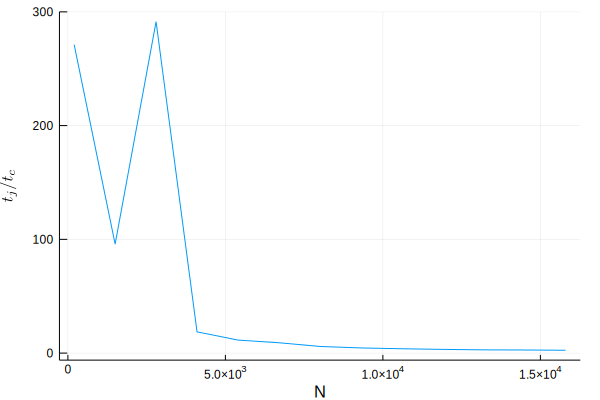

In [23]:
plot(Nrange,time_jl./time_c,xlabel="N",ylabel="\$ t_{j} / t_c \$",legend=:none)

We see that for small $N$ things are much worse. But this is easy to explain/understand: the julia code is being compiled every time we call julia frome the terminal. There is also some overhead associated with the lauching of julia from the terminal, all of which means that for small problems the compilation time dominates. Compiling a julia code statically is a topic for another day, but it could help alleviate the large differences we see in running time for small $N$. Instead of trying to fix this, lets simply push the boundaries of the problem so that our runs take longer. This should dilute any overhead related to the initialization, and benchmark the core, number crunching part of the code:

In [24]:
time_c = []
time_jl = []
Nrange = 16000:4000:64000
for N in Nrange
    cmd = pipeline(`time ./mandelbrot.run $N`, stdout="temp_c.ppm")
    push!(time_c,@elapsed run(cmd))
    cmd = pipeline(`time julia --check-bounds=no -O3 --profile ./src/run.jl $N`, stdout="temp_julia.ppm")
    push!(time_jl,@elapsed run(cmd))
end

        2.38 real         8.32 user         0.05 sys
        5.83 real        14.22 user         0.40 sys
        3.65 real        13.12 user         0.07 sys
        7.05 real        18.38 user         0.29 sys
        5.25 real        18.83 user         0.09 sys
       10.24 real        26.87 user         2.34 sys
        7.14 real        25.60 user         0.13 sys
       13.46 real        36.72 user         2.98 sys
        9.36 real        33.52 user         0.18 sys
       14.24 real        41.13 user         1.08 sys
       12.49 real        40.94 user         0.31 sys
       26.72 real        54.52 user         4.45 sys
       15.89 real        49.92 user         0.48 sys
       27.37 real        69.18 user         7.88 sys
       18.09 real        62.23 user         0.42 sys
       25.84 real        73.70 user         2.59 sys
       21.56 real        74.48 user         0.52 sys
       36.85 real        95.23 user         9.95 sys
       24.59 real        88.62 user         0.

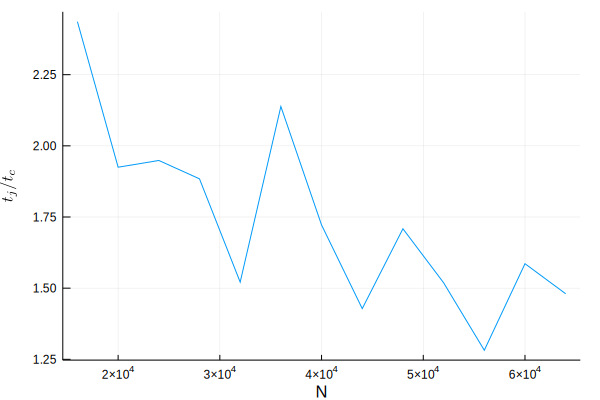

In [25]:
plot(Nrange,time_jl./time_c,xlabel="N",ylabel="\$ t_{j} / t_c \$",legend=:none)

So, forgeting for a second the overhead for the small problems, we managed to get withing a factor of 2 of a pretty low level C code. But that was me coding, and I am not an expert in Julia! So lets see what an expert can do. The fastest version of the mandelbrot I found is [here](https://github.com/KristofferC/BenchmarksGame.jl/blob/master/mandelbrot/mandelbrot-fast.jl). Credits to Simon Danisch. The only small change we will make is to use Float64 in Simon's code, since that is what is used in the C code and we want to be fair. One can check that the results are in fact not equal, for large $N$, if one uses a smaller precision. Lets see how it compares:

In [26]:
time_c = []
time_jl = []
Nrange = 16000:4000:64000
for N in Nrange
    cmd = pipeline(`time ./mandelbrot.run $N`, stdout="temp_c.ppm")
    push!(time_c,@elapsed run(cmd))
    cmd = pipeline(`time julia -O3 --check-bounds=no --profile ./src/mandelbrot-fast.jl $N`, stdout="temp_julia.ppm")
    push!(time_jl,@elapsed run(cmd))
    run(`cmp temp_julia.ppm temp_c.ppm`)
end

        2.36 real         8.33 user         0.05 sys
        3.80 real         8.30 user         0.20 sys
        3.64 real        13.12 user         0.07 sys
        4.44 real        10.77 user         0.20 sys
        5.27 real        18.74 user         0.10 sys
        5.53 real        14.33 user         0.22 sys
        7.14 real        25.66 user         0.13 sys
        6.64 real        18.01 user         0.24 sys
        9.34 real        33.33 user         0.18 sys
        8.04 real        22.49 user         0.27 sys
       11.83 real        42.37 user         0.23 sys
        9.64 real        27.65 user         0.33 sys
       14.55 real        52.13 user         0.26 sys
       11.30 real        32.94 user         0.34 sys
       17.71 real        62.68 user         0.35 sys
       13.35 real        39.85 user         0.41 sys
       21.11 real        75.03 user         0.42 sys
       15.34 real        46.41 user         0.45 sys
       24.65 real        87.97 user         0.

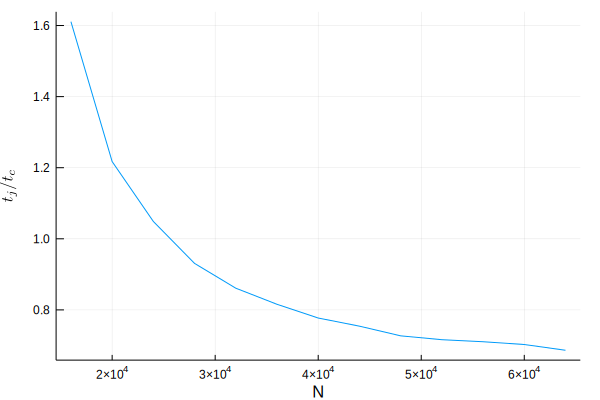

In [27]:
plot(Nrange,time_jl./time_c,xlabel="N",ylabel="\$ t_{j} / t_c \$",legend=:none)

On my machine, we can get to **within C performance** -- that is impressive! In fact Julia is doing a bit better than our C code. Of course this may depend on machines, as well as on the compiler used, but still it is quite a feat for a dynamic language. 

## Conclusions

Our intial goal to solve the challenge was performed rather quickly, using high-level constructions from Julia like list comprehensions and ranges. We saw, however, that the performance of the code was not great. With a bit of work, it was possible to transform the working version into something that exploited both vectorized instructions and multi-threading. The modified version we created, when ignoring the JIT overhead, compared well against the best C code we could find on the internet for the problem at hand. We were better than a factor of two in speed from the C code. 

Taking the comparison one step further, we ran the best Julia version that we could find online, and compared that version to the best C version. We saw a performance comparable to the C code, which is quite impressive for a dynamic language!

Thus, when comparing performance, it apperas that it is possible (and in my option quite feaseable) to write Julia code as performance as optimized C. 